In [1]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from tyxe_runfiles import generate
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [2]:
BASE_DIR = "./tests/underspecified"
PROFILE = "model"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile non-linear-1d-1k ======
Train: (-2, 2)
Y-space: -5.33279118005547 - 2.44630726320173
In Domain: (-2, 2)
Y-space: -5.34177646502616 - 2.5189897426265793
Out Domain: (-4, 4)
Y-space: -11.621171129536249 - 8.498793987886877


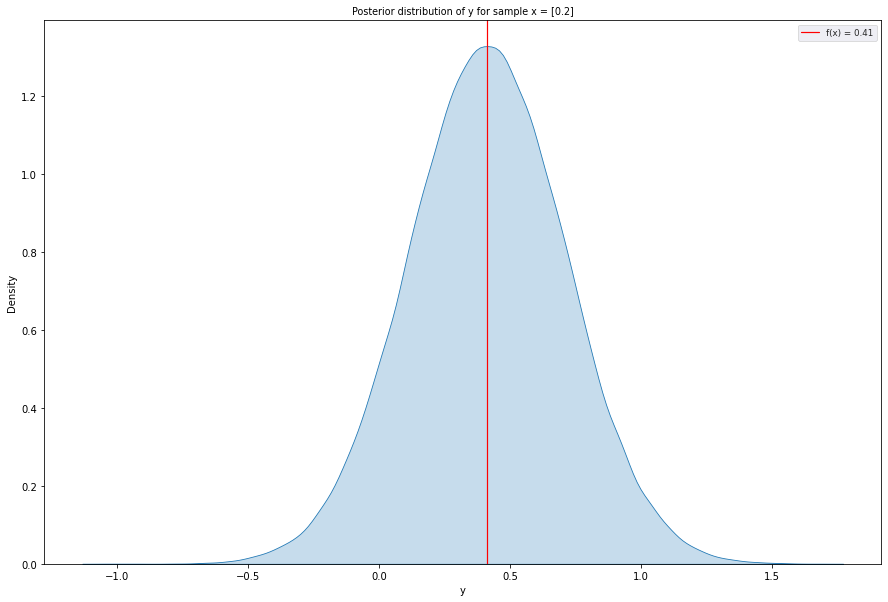

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


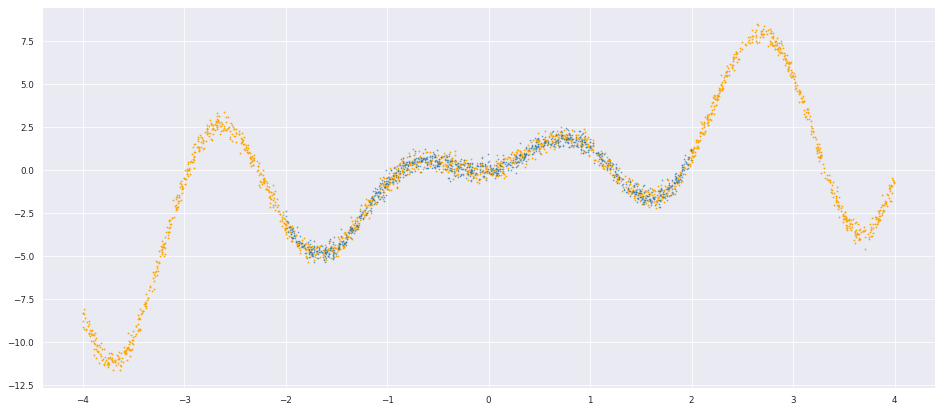

In [7]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [9]:
net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.5), constraint=dist.constraints.positive))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 10.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=1.0)
likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
#likelihood_guide_builder = None

guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [10]:
obs_model._scale

tensor(0.5000, grad_fn=<AddBackward0>)

In [11]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 600, callback)

epoch: 0 | elbo: 13358.867797851562
epoch: 100 | elbo: 10839.860595703125
epoch: 200 | elbo: 8971.896362304688
epoch: 300 | elbo: 7549.209289550781
epoch: 400 | elbo: 6427.489440917969
epoch: 500 | elbo: 5521.278625488281


In [12]:
obs_model._scale

tensor(0.7412, grad_fn=<AddBackward0>)

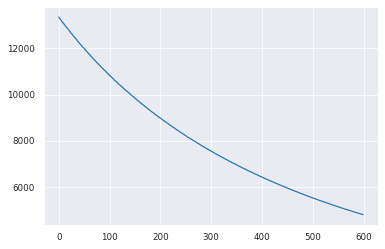

In [13]:
plt.plot(elbos)

In [14]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

scale:  tensor(0.7412, grad_fn=<AddBackward0>)


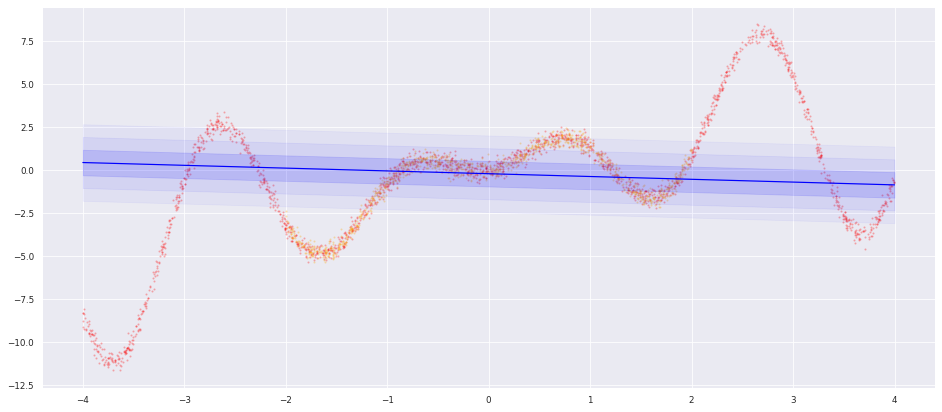

In [15]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

In [38]:
"""MCMC"""

'MCMC'

In [39]:
net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.1), constraint=dist.constraints.positive))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=0.1)

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [40]:
pyro.clear_param_store()

bnn.fit(train_dataloader, num_samples=1000, warmup_steps=1000)

Sample: 100%|██████████| 2000/2000 [00:12, 158.15it/s, step size=6.16e-01, acc. prob=0.903]


In [41]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

scale:  0.1


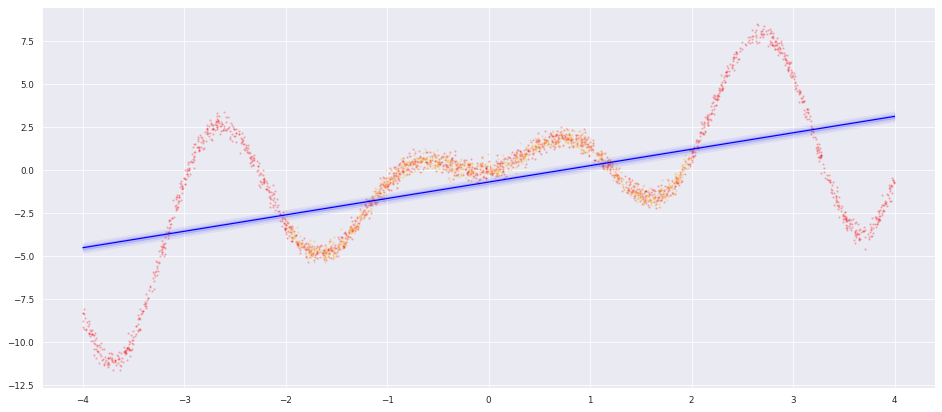

In [42]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

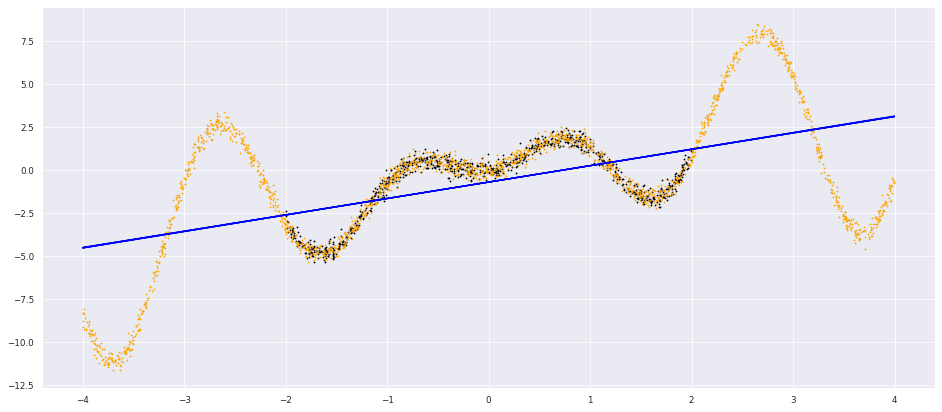

In [43]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [44]:
weight_samples = bnn._mcmc.get_samples(num_samples=10)


In [45]:
weight_samples

{'net.bias': tensor([[-0.6786],
         [-0.6711],
         [-0.6737],
         [-0.6814],
         [-0.6802],
         [-0.6857],
         [-0.6780],
         [-0.6744],
         [-0.6728],
         [-0.6801]]),
 'net.weight': tensor([[[0.9519]],
 
         [[0.9538]],
 
         [[0.9536]],
 
         [[0.9596]],
 
         [[0.9490]],
 
         [[0.9549]],
 
         [[0.9559]],
 
         [[0.9542]],
 
         [[0.9517]],
 
         [[0.9558]]])}

In [46]:
print(x_test[:2])
with poutine.trace() as tr:
    #r = bnn.likelihood(x_test[:2], test=True)
    r = poutine.condition(bnn.likelihood, {"likelihood._scale": 0.1})(x_test[:2], aggregate_mode=True)
r

tensor([[-0.7823],
        [-0.5781]])
scale:  0.1


(tensor([-0.6802]), tensor([0.1756]))

In [47]:
tr.trace.nodes.keys()

odict_keys([])

In [48]:
tr.trace.nodes["likelihood._scale"]

KeyError: 'likelihood._scale'

In [ ]:
tr = poutine.trace(bnn.likelihood).get_trace(x_test[:2])
tr.nodes.keys()

odict_keys(['_INPUT', 'likelihood._scale', 'likelihood.data_plate', 'likelihood.data', '_RETURN'])

In [ ]:
tr.nodes["likelihood._scale"]

{'type': 'sample',
 'name': 'likelihood._scale',
 'fn': Gamma(concentration: 1.0, rate: 1.0),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor(0.1479),
 'infer': {},
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (),
 'done': True,
 'stop': False,
 'continuation': None}